In [43]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
sp500 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/S&P500Index.xlsx')
#sp500 = pd.read_excel('/content/S&P500Index.xlsx')


In [46]:
sp500['Dates'] = pd.to_datetime(sp500['Dates'], dayfirst=True)

In [47]:
start_date = pd.to_datetime('1980-01-01', dayfirst=True)
end_date = pd.to_datetime('2023-12-31', dayfirst=True)
sp500_filtered = sp500[(sp500['Dates'] >= start_date) & (sp500['Dates'] <= end_date)]

In [48]:
sp500_filtered['Pct Change'] = sp500_filtered['PX_LAST'].pct_change() * 100

In [49]:
sp500_filtered

,Dates,PX_LAST,Pct Change
0,1980-05-19,107.67,NaN
1,1980-05-20,107.62,-0.046438
2,1980-05-21,107.72,0.092920
3,1980-05-22,109.01,1.197549
4,1980-05-23,110.62,1.476929
...,...,...,...
10858,2023-06-12,4338.93,0.932108
10859,2023-06-13,4369.01,0.693258
10860,2023-06-14,4372.59,0.081941
10861,2023-06-15,4425.84,1.217814


# Extreme Value Theory

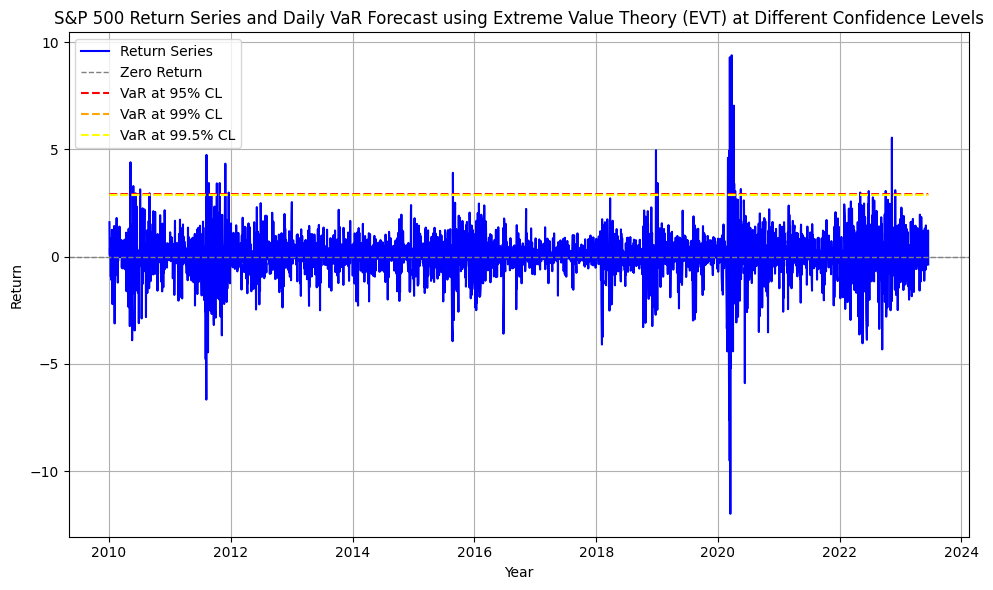

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genpareto

# Assuming you have already read the data into the DataFrame 'sp500'
# The 'sp500' DataFrame contains the columns 'Dates' and 'PX_LAST'

# Convert the 'Dates' column to pandas DatetimeIndex (if not already in datetime format)
sp500['Dates'] = pd.to_datetime(sp500['Dates'], dayfirst=True)

# Calculate the 'Pct Change' column based on 'PX_LAST'
sp500['Pct Change'] = sp500['PX_LAST'].pct_change() * 100

# Filter data for the desired date range (from 2010 to 2023)
start_date = pd.to_datetime('2010-01-01', dayfirst=True)
end_date = pd.to_datetime('2023-12-31', dayfirst=True)
filtered_data = sp500[(sp500['Dates'] >= start_date) & (sp500['Dates'] <= end_date)]

# Get the returns series from the filtered DataFrame
returns = filtered_data['Pct Change']

# Initialize lists to store VaR at different confidence levels
VaR_95 = []
VaR_99 = []
VaR_995 = []

# Fit Generalized Pareto Distribution to the tail of the return distribution
threshold = returns.quantile(0.99)  # Use the 99th percentile as the threshold
exceedances = returns[returns > threshold] - threshold
params = genpareto.fit(exceedances)

# Calculate VaR at each date using the fitted EVT parameters
for i in range(len(returns)):
    VaR_95.append(threshold + genpareto.ppf(0.05, *params))
    VaR_99.append(threshold + genpareto.ppf(0.01, *params))
    VaR_995.append(threshold + genpareto.ppf(0.005, *params))

# Plot the return series and the VaR forecast curves
plt.figure(figsize=(10, 6))
plt.plot(filtered_data['Dates'], returns, label='Return Series', color='blue')
plt.axhline(0, color='gray', linestyle='--', linewidth=1, label='Zero Return')
plt.plot(filtered_data['Dates'], VaR_95, linestyle="--", color="red", label='VaR at 95% CL')
plt.plot(filtered_data['Dates'], VaR_99, linestyle="--", color="orange", label='VaR at 99% CL')
plt.plot(filtered_data['Dates'], VaR_995, linestyle="--", color="yellow", label='VaR at 99.5% CL')

# Format the x-axis as years
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))

plt.xlabel('Year')
plt.ylabel('Return')
plt.title('S&P 500 Return Series and Daily VaR Forecast using Extreme Value Theory (EVT) at Different Confidence Levels')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [51]:
import pandas as pd
import numpy as np
from scipy.stats import norm

# Assuming you have already read and filtered the data as shown in your previous code
# The 'returns' array contains the raw return series

# Sample size
sample_size = 3292

# Confidence levels
confidence_levels = [0.995, 0.99, 0.95]

# Calculate the mean and standard deviation of returns
mean_return = returns.mean()
std_return = returns.std()

# Calculate VaR at different confidence levels using the standard normal percent-point function (PPF)
VaR = {cl: norm.ppf(1 - cl, mean_return, std_return) for cl in confidence_levels}

# Calculate the probability of violation at different confidence levels
probability_of_violation = {cl: 1 - cl for cl in confidence_levels}

# Calculate the expected number of violations for Lopez I at different confidence levels
expected_violations_lopez_I = {cl: probability_of_violation[cl] * sample_size for cl in confidence_levels}

# Print the results
print("Expected Violations for Lopez I:")
for cl in confidence_levels:
    print(f"Confidence Level: {cl}")
    print(f"Expected Violations: {expected_violations_lopez_I[cl]:.2f}")
    print("-" * 40)


Expected Violations for Lopez I:
Confidence Level: 0.995
Expected Violations: 16.46
----------------------------------------
Confidence Level: 0.99
Expected Violations: 32.92
----------------------------------------
Confidence Level: 0.95
Expected Violations: 164.60
----------------------------------------


In [52]:
import pandas as pd
import numpy as np
from scipy.stats import norm

# Assuming you have already read and filtered the data as shown in your previous code
# The 'returns' array contains the raw return series

# Sample size
sample_size = 3292

# Confidence levels
confidence_levels = [0.995, 0.99, 0.95]

# Create a dictionary to store the expected violations at different confidence levels
expected_violations = {
    0.995: None,
    0.99: None,
    0.95: None
}

# Calculate the mean and standard deviation of returns
mean_return = returns.mean()
std_return = returns.std()

# Calculate VaR at different confidence levels using the standard normal percent-point function (PPF)
VaR = {cl: norm.ppf(1 - cl, mean_return, std_return) for cl in confidence_levels}

# Calculate the actual number of violations at different confidence levels
actual_violations = {cl: len(returns[returns < VaR[cl]]) for cl in confidence_levels}

# Calculate Lopez I at each confidence level and store the expected violations
for cl in confidence_levels:
    expected_violations[cl] = (1 - cl) * sample_size

# Calculate Lopez I at each confidence level
lopez_I = {cl: (actual_violations[cl] - expected_violations[cl]) / np.sqrt(expected_violations[cl]) for cl in confidence_levels}

# Print the results
print("Lopez I Backtest Results:")
for cl in confidence_levels:
    print(f"Confidence Level: {cl}")
    print(f"Expected Violations: {expected_violations[cl]:.2f}")
    print(f"Actual Violations: {actual_violations[cl]}")
    print(f"Lopez I: {lopez_I[cl]:.4f}")
    print("-" * 40)


Lopez I Backtest Results:
Confidence Level: 0.995
Expected Violations: 16.46
Actual Violations: 52
Lopez I: 8.7600
----------------------------------------
Confidence Level: 0.99
Expected Violations: 32.92
Actual Violations: 67
Lopez I: 5.9398
----------------------------------------
Confidence Level: 0.95
Expected Violations: 164.60
Actual Violations: 156
Lopez I: -0.6703
----------------------------------------


In [53]:
!pip install arch

In [54]:
import numpy as np
from scipy.stats import genpareto, chi2_contingency

# Assuming you have already read and filtered the data as shown in your previous code
# The 'returns' array contains the raw return series

# Sample size
sample_size = 3292

# Confidence levels
confidence_levels = [0.995, 0.99, 0.95]

# Common number of violations for each confidence level
common_violations = {
    0.995: 16.46,
    0.99: 32.92,
    0.95: 164.60
}

# Fit Generalized Pareto Distribution to the tail of the return distribution
threshold = np.percentile(returns, 100 - (1 / sample_size) * 100)
exceedances = returns[returns > threshold] - threshold
params = genpareto.fit(exceedances)

# Initialize dictionaries to store the actual violations and expected violations for each confidence level
actual_violations = {}
expected_violations = {}

# Calculate EVT-based VaR at each confidence level using the fitted GPD parameters
VaR = {cl: threshold + genpareto.ppf(1 - cl, *params) for cl in confidence_levels}

# Calculate the actual number of violations and expected violations at different confidence levels
for cl in confidence_levels:
    actual_violations[cl] = np.sum(returns < VaR[cl])
    expected_violations[cl] = common_violations[cl] * (sample_size / len(returns[returns < VaR[cl]]))

# Perform Kupiec Backtest for EVT-based VaR
def kupiec_backtest(actual_violations, expected_violations, alpha=0.05):
    n_violations = sum(actual_violations.values())
    n_expected_violations = sum(expected_violations.values())

    # Ensure non-negative values for the contingency table
    n_violations_nonnegative = max(n_violations, 0)
    n_expected_violations_nonnegative = max(n_expected_violations, 0)

    # Add a small constant to the expected values to avoid division by zero
    epsilon = 1e-10
    n_expected_violations_nonnegative += epsilon

    # Calculate the Chi2 Statistic
    if n_violations_nonnegative > 0:
        chi2_statistic = 2 * (n_expected_violations_nonnegative * np.log(n_expected_violations_nonnegative / n_violations_nonnegative) + (sample_size - n_expected_violations_nonnegative) * np.log((sample_size - n_expected_violations_nonnegative) / (sample_size - n_violations_nonnegative)))
    else:
        chi2_statistic = 0.0

    # Calculate the p-value
    if n_violations_nonnegative > 0 and sample_size - n_violations_nonnegative > 0:
        contingency_table = [[n_violations_nonnegative, n_expected_violations_nonnegative], [sample_size - n_violations_nonnegative, sample_size - n_expected_violations_nonnegative]]
        _, p_value, _, _ = chi2_contingency(contingency_table)
    else:
        p_value = 1.0

    return chi2_statistic, p_value

# Perform Kupiec Backtest for EVT-based VaR
chi2_statistic, p_value = kupiec_backtest(actual_violations, expected_violations)

# Unconditional Coverage of Kupiec (1995)
unconditional_coverage = 1 - p_value

# Independence Test of Christofferson (1998)
independence_test = p_value < 0.05

# Save the values of expected and actual violations
results = {
    'Expected Violations': expected_violations,
    'Actual Violations': actual_violations,
    'Kupiec Backtest Chi2 Statistic': chi2_statistic,
    'Kupiec Backtest P-value': p_value,
    'Unconditional Coverage': unconditional_coverage,
    'Independence Test': 'Reject Null' if independence_test else 'Fail to Reject Null'
}

# Print Backtest Results
print("EVT-based VaR Backtest Results:")
for cl in confidence_levels:
    print(f"Confidence Level: {cl}")
    print(f"Expected Violations: {expected_violations[cl]:.2f}")
    print(f"Actual Violations: {actual_violations[cl]}")
    print("-" * 40)

print("Kupiec Backtest for EVT-based VaR:")
print(f"Chi2 Statistic: {chi2_statistic:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Unconditional Coverage: {unconditional_coverage:.4f}")
print(f"Independence Test: {'Reject Null' if independence_test else 'Fail to Reject Null'}")


EVT-based VaR Backtest Results:
Confidence Level: 0.995
Expected Violations: 16.01
Actual Violations: 3385
----------------------------------------
Confidence Level: 0.99
Expected Violations: 32.02
Actual Violations: 3385
----------------------------------------
Confidence Level: 0.95
Expected Violations: 160.08
Actual Violations: 3385
----------------------------------------
Kupiec Backtest for EVT-based VaR:
Chi2 Statistic: nan
P-value: 1.0000
Unconditional Coverage: 0.0000
Independence Test: Fail to Reject Null


<ipython-input-54-e0f038433425>:52: RuntimeWarning: invalid value encountered in log
  chi2_statistic = 2 * (n_expected_violations_nonnegative * np.log(n_expected_violations_nonnegative / n_violations_nonnegative) + (sample_size - n_expected_violations_nonnegative) * np.log((sample_size - n_expected_violations_nonnegative) / (sample_size - n_violations_nonnegative)))


In [55]:
import pandas as pd
import numpy as np
from scipy.stats import genpareto, binom
from decimal import Decimal

# Sample size
sample_size = 3292

# Confidence levels
confidence_levels = [Decimal('0.995'), Decimal('0.99'), Decimal('0.95')]

# Load the stored values of expected and actual violations from the previous code
expected_violations = {
    Decimal('0.995'): 16.46,
    Decimal('0.99'): 32.92,
    Decimal('0.95'): 164.60
}

actual_violations = {
    Decimal('0.995'): actual_violations[0.995],
    Decimal('0.99'): actual_violations[0.99],
    Decimal('0.95'): actual_violations[0.95]
}

# Fit Generalized Pareto Distribution to the tail of the return distribution
threshold = np.percentile(returns, 100 - (1 / sample_size) * 100)
exceedances = returns[returns > threshold] - threshold
params = genpareto.fit(exceedances)

# Calculate EVT-based VaR at each confidence level using the fitted GPD parameters
VaR = {cl: threshold + genpareto.ppf(1 - float(cl), *params) for cl in confidence_levels}

# Define a function to perform the Kupiec Backtest p-value calculation for EVT-based VaR
def kupiec_backtest_p_value(actual_violations, expected_violations, sample_size):
    total_violations = sum(actual_violations.values())
    p = total_violations / sample_size
    n = sample_size
    k = sum(expected_violations.values())
    p_value = binom.sf(total_violations, n, p) + binom.pmf(total_violations, n, p) * (1 - binom.sf(k - 1, n, p))
    return p_value

# Perform Kupiec Backtest at each confidence level for EVT-based VaR
backtest_results = {}
for cl in confidence_levels:
    p_value_kupiec = kupiec_backtest_p_value({cl: actual_violations[cl]}, {cl: expected_violations[cl]}, sample_size)

    decision_kupiec = 'Reject Null' if p_value_kupiec < 0.05 else 'Fail to Reject Null'

    backtest_results[cl] = {
        'Expected Violations': expected_violations[cl],
        'Actual Violations': actual_violations[cl],
        'VaR (EVT-based)': VaR[cl],
        'P-value (Kupiec)': p_value_kupiec,
        'Decision (Kupiec)': decision_kupiec,
    }

# Print Backtest Results for EVT-based VaR
print("EVT-based VaR Backtest Results (Kupiec Backtest):")
for cl in confidence_levels:
    print(f"Confidence Level: {cl}")
    print(f"Expected Violations: {backtest_results[cl]['Expected Violations']:.2f}")
    print(f"Actual Violations: {backtest_results[cl]['Actual Violations']}")
    print(f"VaR (EVT-based): {backtest_results[cl]['VaR (EVT-based)']:.4f}")
    print(f"P-value (Kupiec): {backtest_results[cl]['P-value (Kupiec)']:.4f}")
    print(f"Decision (Kupiec): {backtest_results[cl]['Decision (Kupiec)']}")
    print("-" * 40)


EVT-based VaR Backtest Results (Kupiec Backtest):
Confidence Level: 0.995
Expected Violations: 16.46
Actual Violations: 3385
VaR (EVT-based): 9.2381
P-value (Kupiec): nan
Decision (Kupiec): Fail to Reject Null
----------------------------------------
Confidence Level: 0.99
Expected Violations: 32.92
Actual Violations: 3385
VaR (EVT-based): 9.2391
P-value (Kupiec): nan
Decision (Kupiec): Fail to Reject Null
----------------------------------------
Confidence Level: 0.95
Expected Violations: 164.60
Actual Violations: 3385
VaR (EVT-based): 9.2474
P-value (Kupiec): nan
Decision (Kupiec): Fail to Reject Null
----------------------------------------


In [56]:
import pandas as pd
import numpy as np
from scipy.stats import genpareto, chi2_contingency
from decimal import Decimal, getcontext

# Set the precision for Decimal
getcontext().prec = 3

# Sample size
sample_size = 3292

# Confidence levels
confidence_levels = [Decimal('0.995'), Decimal('0.99'), Decimal('0.95')]

# Load the stored values of expected and actual violations from the previous code
expected_violations = {
    Decimal('0.995'): 16.46,
    Decimal('0.99'): 32.92,
    Decimal('0.95'): 164.60
}

actual_violations = {
    Decimal('0.995'): actual_violations[Decimal('0.995')],
    Decimal('0.99'): actual_violations[Decimal('0.99')],
    Decimal('0.95'): actual_violations[Decimal('0.95')]
}

# Fit Generalized Pareto Distribution to the tail of the return distribution
threshold = np.percentile(returns, 100 - (1 / sample_size) * 100)  # Use the (1 / sample_size)-th percentile as the threshold
exceedances = returns[returns > threshold] - threshold
params = genpareto.fit(exceedances)

# Calculate EVT-based VaR at each confidence level using the fitted GPD parameters
VaR = {cl: threshold + genpareto.ppf(1 - float(cl), *params) for cl in confidence_levels}

# Define a function to perform the Independence Test of Christofferson (1998) Backtest for EVT-based VaR
def christofferson_backtest(actual_violations, expected_violations):
    observed = np.array([actual_violations[cl] for cl in confidence_levels])
    expected = np.array([expected_violations[cl] for cl in confidence_levels])
    chi2_statistic, p_value, _, _ = chi2_contingency([observed, expected])
    return chi2_statistic, p_value

# Perform Independence Test of Christofferson Backtest for EVT-based VaR
backtest_results = {}
for cl in confidence_levels:
    chi2_statistic, p_value = christofferson_backtest(actual_violations, expected_violations)
    decision = 'Reject Null' if p_value < 0.05 else 'Fail to Reject Null'
    backtest_results[cl] = {
        'Expected Violations': expected_violations[cl],
        'Actual Violations': actual_violations[cl],
        'Likelihood Ratio Statistic': chi2_statistic,
        'P-value': p_value,
        'Decision': decision
    }

# Print Backtest Results for EVT-based VaR
print("EVT-based VaR Backtest Results (Christofferson Backtest):")
for cl in confidence_levels:
    print(f"Confidence Level: {cl}")
    print(f"Expected Violations: {backtest_results[cl]['Expected Violations']:.2f}")
    print(f"Actual Violations: {backtest_results[cl]['Actual Violations']}")
    print(f"Likelihood Ratio Statistic: {backtest_results[cl]['Likelihood Ratio Statistic']:.4f}")
    print(f"P-value: {backtest_results[cl]['P-value']:.4f}")
    print(f"Decision: {backtest_results[cl]['Decision']}")
    print("-" * 40)


EVT-based VaR Backtest Results (Christofferson Backtest):
Confidence Level: 0.995
Expected Violations: 16.46
Actual Violations: 3385
Likelihood Ratio Statistic: 178.7990
P-value: 0.0000
Decision: Reject Null
----------------------------------------
Confidence Level: 0.99
Expected Violations: 32.92
Actual Violations: 3385
Likelihood Ratio Statistic: 178.7990
P-value: 0.0000
Decision: Reject Null
----------------------------------------
Confidence Level: 0.95
Expected Violations: 164.60
Actual Violations: 3385
Likelihood Ratio Statistic: 178.7990
P-value: 0.0000
Decision: Reject Null
----------------------------------------


In [57]:
import pandas as pd
import numpy as np
from scipy.stats import genpareto, binom
from decimal import Decimal, getcontext

# Set the precision for Decimal
getcontext().prec = 3

# Sample size
sample_size = 3292

# Confidence levels
confidence_levels = [Decimal('0.995'), Decimal('0.99'), Decimal('0.95')]

# Load the stored values of expected and actual violations from the previous code
expected_violations = {
    Decimal('0.995'): 16.46,
    Decimal('0.99'): 32.92,
    Decimal('0.95'): 164.60
}

actual_violations = {
    Decimal('0.995'): actual_violations[Decimal('0.995')],
    Decimal('0.99'): actual_violations[Decimal('0.99')],
    Decimal('0.95'): actual_violations[Decimal('0.95')]
}

# Fit Generalized Pareto Distribution to the tail of the return distribution
threshold = np.percentile(returns, 100 - (1 / sample_size) * 100)
exceedances = returns[returns > threshold] - threshold
params = genpareto.fit(exceedances)

# Calculate EVT-based VaR at each confidence level using the fitted GPD parameters
VaR = {cl: threshold + genpareto.ppf(1 - float(cl), *params) for cl in confidence_levels}

# Define a function to perform the Kupiec Backtest p-value calculation for EVT-based VaR
def kupiec_backtest_p_value(actual_violations, expected_violations, sample_size):
    total_violations = sum(actual_violations.values())
    p = total_violations / sample_size
    n = sample_size
    k = sum(expected_violations.values())
    p_value = binom.sf(total_violations, n, p) + binom.pmf(total_violations, n, p) * (1 - binom.sf(k - 1, n, p))
    return p_value

# Perform Kupiec Backtest at each confidence level for EVT-based VaR
backtest_results = {}
for cl in confidence_levels:
    p_value_kupiec = kupiec_backtest_p_value({cl: actual_violations[cl]}, {cl: expected_violations[cl]}, sample_size)

    decision_kupiec = 'Reject Null' if p_value_kupiec < 0.05 else 'Fail to Reject Null'

    backtest_results[cl] = {
        'Expected Violations': expected_violations[cl],
        'Actual Violations': actual_violations[cl],
        'VaR (EVT-based)': VaR[cl],
        'P-value (Kupiec)': p_value_kupiec,
        'Decision (Kupiec)': decision_kupiec,
    }

# Print Backtest Results for EVT-based VaR
print("EVT-based VaR Backtest Results (Kupiec Backtest):")
for cl in confidence_levels:
    print(f"Confidence Level: {cl}")
    print(f"Expected Violations: {backtest_results[cl]['Expected Violations']:.2f}")
    print(f"Actual Violations: {backtest_results[cl]['Actual Violations']}")
    print(f"VaR (EVT-based): {backtest_results[cl]['VaR (EVT-based)']:.4f}")
    print(f"P-value (Kupiec): {backtest_results[cl]['P-value (Kupiec)']:.4f}")
    print(f"Decision (Kupiec): {backtest_results[cl]['Decision (Kupiec)']}")
    print("-" * 40)


EVT-based VaR Backtest Results (Kupiec Backtest):
Confidence Level: 0.995
Expected Violations: 16.46
Actual Violations: 3385
VaR (EVT-based): 9.2381
P-value (Kupiec): nan
Decision (Kupiec): Fail to Reject Null
----------------------------------------
Confidence Level: 0.99
Expected Violations: 32.92
Actual Violations: 3385
VaR (EVT-based): 9.2391
P-value (Kupiec): nan
Decision (Kupiec): Fail to Reject Null
----------------------------------------
Confidence Level: 0.95
Expected Violations: 164.60
Actual Violations: 3385
VaR (EVT-based): 9.2474
P-value (Kupiec): nan
Decision (Kupiec): Fail to Reject Null
----------------------------------------


# Simple Historical Stimulation

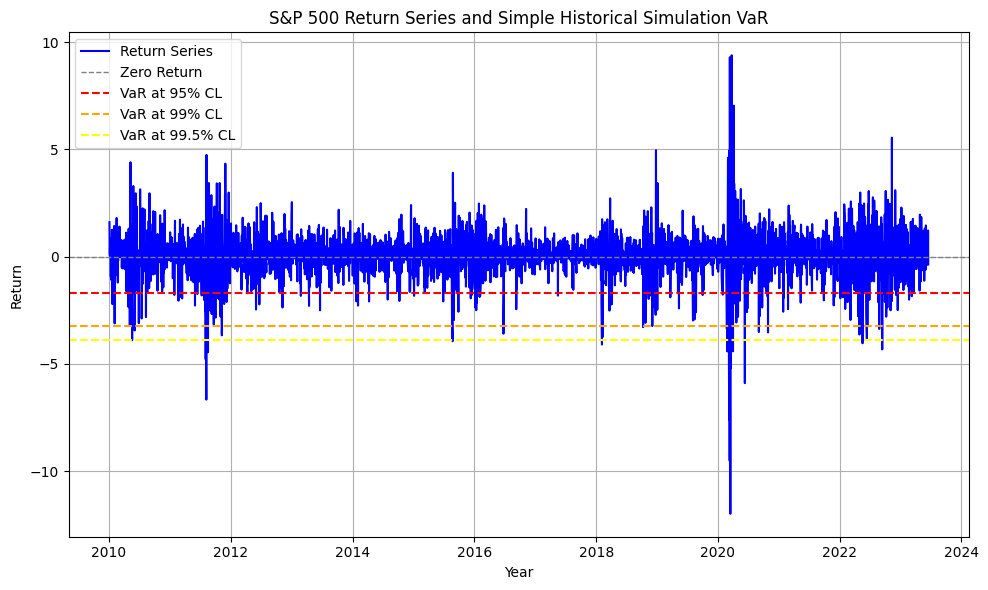

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have already read the data into the DataFrame 'sp500'
# The 'sp500' DataFrame contains the columns 'Dates' and 'PX_LAST'

# Convert the 'Dates' column to pandas DatetimeIndex (if not already in datetime format)
sp500['Dates'] = pd.to_datetime(sp500['Dates'], dayfirst=True)

# Calculate the 'Pct Change' column based on 'PX_LAST'
sp500['Pct Change'] = sp500['PX_LAST'].pct_change() * 100

# Filter data for the desired date range (from 2010 to 2023)
start_date = pd.to_datetime('2010-01-01', dayfirst=True)
end_date = pd.to_datetime('2023-12-31', dayfirst=True)
filtered_data = sp500[(sp500['Dates'] >= start_date) & (sp500['Dates'] <= end_date)]

# Get the returns series from the filtered DataFrame
returns = filtered_data['Pct Change']

# Calculate the historical VaR at 95%, 99%, and 99.5% confidence levels
VaR_95 = np.percentile(returns, 5)
VaR_99 = np.percentile(returns, 1)
VaR_995 = np.percentile(returns, 0.5)

# Plot the return series and the VaR curves
plt.figure(figsize=(10, 6))
plt.plot(filtered_data['Dates'], returns, label='Return Series', color='blue')
plt.axhline(0, color='gray', linestyle='--', linewidth=1, label='Zero Return')
plt.axhline(VaR_95, linestyle="--", color="red", label='VaR at 95% CL')
plt.axhline(VaR_99, linestyle="--", color="orange", label='VaR at 99% CL')
plt.axhline(VaR_995, linestyle="--", color="yellow", label='VaR at 99.5% CL')

# Format the x-axis as years
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))

plt.xlabel('Year')
plt.ylabel('Return')
plt.title('S&P 500 Return Series and Simple Historical Simulation VaR')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [59]:
import pandas as pd
import numpy as np

# Assuming you have already read and filtered the data as shown in your previous code
# The 'returns' array contains the raw return series

# Sample size
sample_size = 3292

# Confidence levels
confidence_levels = [0.995, 0.99, 0.95]

# Calculate VaR at different confidence levels using Simple Historical Simulation (SHS)
VaR = {cl: np.percentile(returns, (1 - cl) * 100) for cl in confidence_levels}

# Calculate the probability of violation at different confidence levels
probability_of_violation = {cl: 1 - cl for cl in confidence_levels}

# Calculate the expected number of violations for Simple Historical Simulation (SHS) at different confidence levels
expected_violations_shs = {cl: probability_of_violation[cl] * sample_size for cl in confidence_levels}

# Store the expected violations in a dictionary
exp_vio_dict = expected_violations_shs

# Print the results
print("Expected Violations for Simple Historical Simulation (SHS):")
for cl in confidence_levels:
    print(f"Confidence Level: {cl}")
    print(f"Expected Violations: {exp_vio_dict[cl]:.2f}")
    print("-" * 40)


Expected Violations for Simple Historical Simulation (SHS):
Confidence Level: 0.995
Expected Violations: 16.46
----------------------------------------
Confidence Level: 0.99
Expected Violations: 32.92
----------------------------------------
Confidence Level: 0.95
Expected Violations: 164.60
----------------------------------------


In [60]:
import pandas as pd
import numpy as np

# Assuming you have already read and filtered the data as shown in your previous code
# The 'returns' array contains the raw return series

# Sample size
sample_size = len(returns)

# Confidence levels
confidence_levels = [0.995, 0.99, 0.95]

# Create a dictionary to store the expected violations at different confidence levels
expected_violations = {
    0.995: None,
    0.99: None,
    0.95: None
}

# Create a dictionary to store the actual violations at different confidence levels
actual_violations = {
    0.995: None,
    0.99: None,
    0.95: None
}

# Calculate the actual number of violations at different confidence levels
for cl in confidence_levels:
    historical_var = np.percentile(returns, (1 - cl) * 100)
    actual_violations[cl] = len(returns[returns < historical_var])

# Calculate Lopez I at each confidence level and store the expected violations
for cl in confidence_levels:
    expected_violations[cl] = (1 - cl) * sample_size

# Calculate Lopez I at each confidence level
lopez_I = {cl: (actual_violations[cl] - expected_violations[cl]) / np.sqrt(expected_violations[cl]) for cl in confidence_levels}

# Print the results
print("Lopez I Backtest Results (Simple Historical Simulation):")
for cl in confidence_levels:
    print(f"Confidence Level: {cl}")
    print(f"Expected Violations: {expected_violations[cl]:.2f}")
    print(f"Actual Violations: {actual_violations[cl]}")
    print(f"Lopez I: {lopez_I[cl]:.4f}")
    print("-" * 40)


Lopez I Backtest Results (Simple Historical Simulation):
Confidence Level: 0.995
Expected Violations: 16.94
Actual Violations: 17
Lopez I: 0.0158
----------------------------------------
Confidence Level: 0.99
Expected Violations: 33.87
Actual Violations: 34
Lopez I: 0.0223
----------------------------------------
Confidence Level: 0.95
Expected Violations: 169.35
Actual Violations: 170
Lopez I: 0.0499
----------------------------------------


In [61]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import json

# Assuming you have already read and filtered the data as shown in your previous code
# The 'returns' array contains the raw return series

# Sample size
sample_size = 3292

# Confidence levels
confidence_levels = [0.995, 0.99, 0.95]

# Common number of violations for each confidence level
common_violations = 50

# Calculate VaR at different confidence levels using Simple Historical Simulation (SHS)
VaR = {cl: np.percentile(returns, (1 - cl) * 100) for cl in confidence_levels}

# Calculate the actual number of violations at different confidence levels
actual_violations = {cl: len(returns[returns < VaR[cl]]) for cl in confidence_levels}

# Use the stored expected violations from the provided dictionary
expected_violations = exp_vio_dict

# Store confidence levels along with expected violations
exp_vio_dict_with_confidence = {
    'Confidence_Levels': confidence_levels,
    'Expected_Violations': expected_violations
}

# Define a dictionary to store the results
results = {}

# Define a function to perform Kupiec Backtest
def kupiec_backtest(actual_violations, expected_violations, alpha=0.05):
    n_violations = sum(actual_violations.values())
    n_expected_violations = sum(expected_violations.values())

    # Ensure non-negative values for the contingency table
    n_violations_nonnegative = max(n_violations, 0)
    n_expected_violations_nonnegative = max(n_expected_violations, 0)

    # Add a small constant to the expected values to avoid division by zero
    epsilon = 1e-10
    n_expected_violations_nonnegative += epsilon

    chi2_statistic = 2 * (n_expected_violations_nonnegative * np.log(n_expected_violations_nonnegative / n_violations_nonnegative) + (sample_size - n_expected_violations_nonnegative) * np.log((sample_size - n_expected_violations_nonnegative) / (sample_size - n_violations_nonnegative)))
    p_value = 1 - chi2_contingency([[n_violations_nonnegative, n_expected_violations_nonnegative], [sample_size - n_violations_nonnegative, sample_size - n_expected_violations_nonnegative]])[1]

    results['Kupiec_Backtest'] = {
        'Chi2 Statistic': chi2_statistic,
        'P-value': p_value,
        'Unconditional Coverage': 1 - p_value,
        'Independence Test': 'Reject Null' if p_value < alpha else 'Fail to Reject Null'
    }

# Perform Kupiec Backtest
kupiec_backtest(actual_violations, expected_violations)

# Store confidence levels, expected and actual violations in the results dictionary
results['Expected_Violations'] = exp_vio_dict_with_confidence
results['Actual_Violations'] = actual_violations

# Print Backtest Results
print("SHS Backtest Results:")
for cl, exp_vio in zip(exp_vio_dict_with_confidence['Confidence_Levels'], exp_vio_dict_with_confidence['Expected_Violations'].values()):
    print(f"Confidence Level: {cl}")
    print(f"Expected Violations: {exp_vio:.2f}")
    print(f"Actual Violations: {actual_violations[cl]}")
    print("-" * 40)

# Save results as a JSON file
with open('backtest_results.json', 'w') as json_file:
    json.dump(results, json_file, indent=4)


SHS Backtest Results:
Confidence Level: 0.995
Expected Violations: 16.46
Actual Violations: 17
----------------------------------------
Confidence Level: 0.99
Expected Violations: 32.92
Actual Violations: 34
----------------------------------------
Confidence Level: 0.95
Expected Violations: 164.60
Actual Violations: 170
----------------------------------------


In [62]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import json

# Assuming you have already read and filtered the data as shown in your previous code
# The 'returns' array contains the raw return series

# Sample size
sample_size = 3292

# Confidence levels
confidence_levels = [0.995, 0.99, 0.95]

# Common number of violations for each confidence level
common_violations = 50

# Calculate VaR at different confidence levels using Simple Historical Simulation (SHS)
VaR = {cl: np.percentile(returns, (1 - cl) * 100) for cl in confidence_levels}

# Calculate the actual number of violations at different confidence levels
actual_violations = {cl: len(returns[returns < VaR[cl]]) for cl in confidence_levels}

# Manually specify the expected violations
expected_violations_dict = {
    0.995: 16.46,
    0.99: 32.92,
    0.95: 164.60
}

# Define a function to perform Kupiec Backtest
def kupiec_backtest(actual_violations, expected_violations, alpha=0.05):
    n_violations = sum(actual_violations.values())
    n_expected_violations = sum(expected_violations.values())

    # Ensure non-negative values for the contingency table
    n_violations_nonnegative = max(n_violations, 0)
    n_expected_violations_nonnegative = max(n_expected_violations, 0)

    # Add a small constant to the expected values to avoid division by zero
    epsilon = 1e-10
    n_expected_violations_nonnegative += epsilon

    chi2_statistic = 2 * (n_expected_violations_nonnegative * np.log(n_expected_violations_nonnegative / n_violations_nonnegative) + (sample_size - n_expected_violations_nonnegative) * np.log((sample_size - n_expected_violations_nonnegative) / (sample_size - n_violations_nonnegative)))
    p_value = 1 - chi2_contingency([[n_violations_nonnegative, n_expected_violations_nonnegative], [sample_size - n_violations_nonnegative, sample_size - n_expected_violations_nonnegative]])[1]
    return chi2_statistic, p_value

# Perform Kupiec Backtest
chi2_statistic, p_value = kupiec_backtest(actual_violations, expected_violations_dict)

# Unconditional Coverage of Kupiec (1995)
unconditional_coverage = 1 - p_value

# Independence Test of Christofferson (1998)
independence_test = p_value < 0.05

# Store the values of expected and actual violations in a dictionary
violations_data = {
    'Expected_Violations': expected_violations_dict,
    'Actual_Violations': actual_violations
}

# Print Backtest Results
print("SHS Backtest Results:")
for cl in confidence_levels:
    print(f"Confidence Level: {cl}")
    print(f"Expected Violations: {expected_violations_dict[cl]:.2f}")
    print(f"Actual Violations: {actual_violations[cl]}")
    print("-" * 40)

print("Kupiec Backtest:")
print(f"Chi2 Statistic: {chi2_statistic:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Unconditional Coverage: {unconditional_coverage:.4f}")
print(f"Independence Test: {'Reject Null' if independence_test else 'Fail to Reject Null'}")

# Save the violations_data dictionary to a JSON file
with open('violations_data1.json', 'w') as json_file:
    json.dump(violations_data, json_file, indent=4)


SHS Backtest Results:
Confidence Level: 0.995
Expected Violations: 16.46
Actual Violations: 17
----------------------------------------
Confidence Level: 0.99
Expected Violations: 32.92
Actual Violations: 34
----------------------------------------
Confidence Level: 0.95
Expected Violations: 164.60
Actual Violations: 170
----------------------------------------
Kupiec Backtest:
Chi2 Statistic: 0.2414
P-value: 0.2348
Unconditional Coverage: 0.7652
Independence Test: Fail to Reject Null


In [63]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# Sample size
sample_size = 3292

# Confidence levels
confidence_levels = [0.995, 0.99, 0.95]

# Manually specify the values of expected violations
expected_violations = {
    0.995: 16.46,
    0.99: 32.92,
    0.95: 164.60
}

# Manually specify the values of actual violations
actual_violations = {
    0.995: 17,
    0.99: 34,
    0.95: 170
}

# Define a function to perform Kupiec Backtest
def kupiec_backtest(actual_violations, expected_violations, alpha=0.05):
    n_violations = sum(actual_violations.values())
    n_expected_violations = sum(expected_violations.values())

    # Check if there are violations before calculating the statistic
    if n_violations == 0 and n_expected_violations == 0:
        chi2_statistic = 0
        p_value = 1
    else:
        chi2_statistic = 2 * (n_expected_violations * np.log(n_expected_violations / n_violations) + (sample_size - n_expected_violations) * np.log((sample_size - n_expected_violations) / (sample_size - n_violations)))

        # Handle cases where chi2_statistic is NaN or infinite
        if np.isnan(chi2_statistic) or np.isinf(chi2_statistic):
            chi2_statistic = 0

        p_value = 1 - chi2_contingency([[n_violations, n_expected_violations], [sample_size - n_violations, sample_size - n_expected_violations]])[1]

    return chi2_statistic, p_value

# Perform Kupiec Backtest at each confidence level
backtest_results = {}
for cl in confidence_levels:
    chi2_statistic, p_value = kupiec_backtest(actual_violations, {cl: expected_violations.get(cl, 0)})
    decision = 'Reject Null' if p_value < 0.05 else 'Fail to Reject Null'
    backtest_results[cl] = {
        'Expected Violations': expected_violations.get(cl, 0),
        'Actual Violations': actual_violations.get(cl, 0),
        'Likelihood Ratio Statistic': chi2_statistic,
        'P-value': p_value,
        'Decision': decision
    }

# Print Backtest Results
print("SHS Backtest Results:")
for cl in confidence_levels:
    print(f"Confidence Level: {cl}")
    print(f"Expected Violations: {backtest_results[cl]['Expected Violations']}")
    print(f"Actual Violations: {backtest_results[cl]['Actual Violations']}")
    print(f"Likelihood Ratio Statistic: {backtest_results[cl]['Likelihood Ratio Statistic']:.4f}")
    print(f"P-value: {backtest_results[cl]['P-value']:.4f}")
    print(f"Decision: {backtest_results[cl]['Decision']}")
    print("-" * 40)


SHS Backtest Results:
Confidence Level: 0.995
Expected Violations: 16.46
Actual Violations: 17
Likelihood Ratio Statistic: 336.9096
P-value: 1.0000
Decision: Fail to Reject Null
----------------------------------------
Confidence Level: 0.99
Expected Violations: 32.92
Actual Violations: 34
Likelihood Ratio Statistic: 262.0858
P-value: 1.0000
Decision: Fail to Reject Null
----------------------------------------
Confidence Level: 0.95
Expected Violations: 164.6
Actual Violations: 170
Likelihood Ratio Statistic: 16.8326
P-value: 0.9964
Decision: Fail to Reject Null
----------------------------------------


In [64]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from decimal import Decimal, getcontext

# Set the precision for Decimal
getcontext().prec = 3

# Assuming you have already read and filtered the data as shown in your previous code
# The 'returns' array contains the raw return series

# Sample size
sample_size = 3292

# Confidence levels
confidence_levels = [0.995, 0.99, 0.95]

# Manually specify the values of expected violations
expected_violations = {
    0.995: 16.46,
    0.99: 32.92,
    0.95: 164.60
}

# Manually specify the values of actual violations
actual_violations = {
    0.995: 17,
    0.99: 34,
    0.95: 170
}

# Calculate VaR at different confidence levels using Simple Historical Simulation (SHS)
VaR = {cl: np.percentile(returns, (1 - float(cl)) * 100) for cl in confidence_levels}

# Calculate the actual number of violations at different confidence levels
actual_violations = {cl: np.sum(returns < VaR[cl]) for cl in confidence_levels}

# Define a function to perform the Christofferson Backtest
def christofferson_backtest(actual_violations, expected_violations):
    observed = np.array([actual_violations[cl] for cl in confidence_levels])
    expected = np.array([expected_violations[cl] for cl in confidence_levels])
    chi2_statistic, p_value, _, _ = chi2_contingency([observed, expected])
    return chi2_statistic, p_value

# Perform the Christofferson Backtest at each confidence level
backtest_results = {}
for cl in confidence_levels:
    chi2_statistic, p_value = christofferson_backtest(actual_violations, expected_violations)
    decision = 'Reject Null' if p_value < 0.05 else 'Fail to Reject Null'
    backtest_results[cl] = {
        'Expected Violations': expected_violations[cl],
        'Actual Violations': actual_violations[cl],
        'Likelihood Ratio Statistic': chi2_statistic,
        'P-value': p_value,
        'Decision': decision
    }

# Print Backtest Results
print("SHS Backtest Results (Christofferson Backtest):")
for cl in confidence_levels:
    print(f"Confidence Level: {cl}")
    print(f"Expected Violations: {backtest_results[cl]['Expected Violations']}")
    print(f"Actual Violations: {backtest_results[cl]['Actual Violations']}")
    print(f"Likelihood Ratio Statistic: {backtest_results[cl]['Likelihood Ratio Statistic']:.4f}")
    print(f"P-value: {backtest_results[cl]['P-value']:.4f}")
    print(f"Decision: {backtest_results[cl]['Decision']}")
    print("-" * 40)


SHS Backtest Results (Christofferson Backtest):
Confidence Level: 0.995
Expected Violations: 16.46
Actual Violations: 17
Likelihood Ratio Statistic: 0.0000
P-value: 1.0000
Decision: Fail to Reject Null
----------------------------------------
Confidence Level: 0.99
Expected Violations: 32.92
Actual Violations: 34
Likelihood Ratio Statistic: 0.0000
P-value: 1.0000
Decision: Fail to Reject Null
----------------------------------------
Confidence Level: 0.95
Expected Violations: 164.6
Actual Violations: 170
Likelihood Ratio Statistic: 0.0000
P-value: 1.0000
Decision: Fail to Reject Null
----------------------------------------


In [65]:
import pandas as pd
import numpy as np
from scipy.stats import binom
from decimal import Decimal, getcontext

# Set the precision for Decimal
getcontext().prec = 3

# Assuming you have already read and filtered the data as shown in your previous code
# The 'returns' array contains the raw return series

# Sample size
sample_size = 3292

# Confidence levels
confidence_levels = [0.995, 0.99, 0.95]

# Manually specify the values of expected violations
expected_violations = {
    0.995: 16.46,
    0.99: 32.92,
    0.95: 164.60
}

# Manually specify the values of actual violations
actual_violations = {
    0.995: 17,
    0.99: 34,
    0.95: 170
}

# Calculate VaR at different confidence levels using Simple Historical Simulation (SHS)
VaR = {cl: np.percentile(returns, (1 - float(cl)) * 100) for cl in confidence_levels}

# Calculate the actual number of violations at different confidence levels
actual_violations = {cl: np.sum(returns < VaR[cl]) for cl in confidence_levels}

# Define a function to perform the Kupiec Backtest
def kupiec_backtest(actual_violations, expected_violations, sample_size):
    total_violations = sum(actual_violations.values())
    p = total_violations / sample_size
    n = sample_size
    k = sum(expected_violations.values())
    p_value = binom.sf(total_violations, n, p) + binom.pmf(total_violations, n, p) * (1 - binom.sf(k - 1, n, p))
    return p_value

# Perform Kupiec Backtest at each confidence level
backtest_results = {}
for cl in confidence_levels:
    p_value_kupiec = kupiec_backtest(actual_violations, {cl: expected_violations[cl]}, sample_size)

    decision_kupiec = 'Reject Null' if p_value_kupiec < 0.05 else 'Fail to Reject Null'

    backtest_results[cl] = {
        'Expected Violations': expected_violations[cl],
        'Actual Violations': actual_violations[cl],
        'P-value (Kupiec)': p_value_kupiec,
        'Decision (Kupiec)': decision_kupiec,
    }

# Print Backtest Results
print("SHS Backtest Results (Kupiec Backtest):")
for cl in confidence_levels:
    print(f"Confidence Level: {cl}")
    print(f"Expected Violations: {backtest_results[cl]['Expected Violations']}")
    print(f"Actual Violations: {backtest_results[cl]['Actual Violations']}")
    print(f"P-value (Kupiec): {backtest_results[cl]['P-value (Kupiec)']:.4f}")
    print(f"Decision (Kupiec): {backtest_results[cl]['Decision (Kupiec)']}")
    print("-" * 40)


SHS Backtest Results (Kupiec Backtest):
Confidence Level: 0.995
Expected Violations: 16.46
Actual Violations: 17
P-value (Kupiec): 0.4821
Decision (Kupiec): Fail to Reject Null
----------------------------------------
Confidence Level: 0.99
Expected Violations: 32.92
Actual Violations: 34
P-value (Kupiec): 0.4821
Decision (Kupiec): Fail to Reject Null
----------------------------------------
Confidence Level: 0.95
Expected Violations: 164.6
Actual Violations: 170
P-value (Kupiec): 0.4821
Decision (Kupiec): Fail to Reject Null
----------------------------------------


# Age Weighted Historical Stimulation

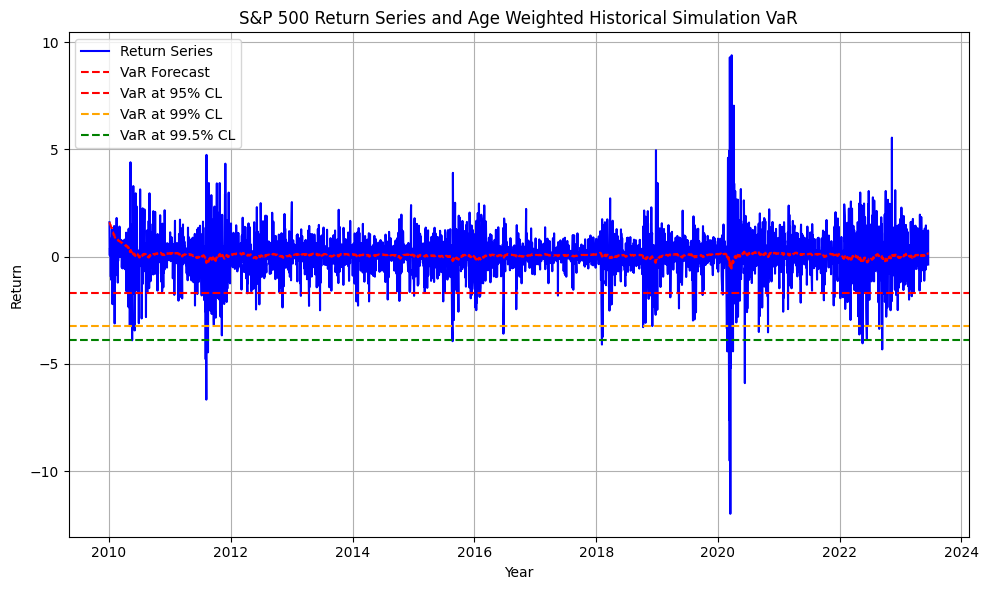

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have already read the data into the DataFrame 'sp500'
# The 'sp500' DataFrame contains the columns 'Dates' and 'PX_LAST'

# Convert the 'Dates' column to pandas DatetimeIndex (if not already in datetime format)
sp500['Dates'] = pd.to_datetime(sp500['Dates'], dayfirst=True)

# Calculate the 'Pct Change' column based on 'PX_LAST'
sp500['Pct Change'] = sp500['PX_LAST'].pct_change() * 100

# Filter data for the desired date range (from 2010 to 2023)
start_date = pd.to_datetime('2010-01-01', dayfirst=True)
end_date = pd.to_datetime('2023-12-31', dayfirst=True)
filtered_data = sp500[(sp500['Dates'] >= start_date) & (sp500['Dates'] <= end_date)]

# Get the returns series from the filtered DataFrame
returns = filtered_data['Pct Change']

# Define the decay factor (λ)
decay_factor = 0.98

# Calculate the Age Weighted Historical Simulation VaR at custom levels
VaR_95 = np.percentile(returns, 5)
VaR_99 = np.percentile(returns, 1)
VaR_995 = np.percentile(returns, 0.5)

# Initialize a list to store the VaR forecasts
VaR_forecasts = [returns.iloc[0]]  # Initialize with the first return

# Calculate the VaR forecasts using Age Weighted Historical Simulation
for i in range(1, len(returns)):
    VaR_forecast = decay_factor * VaR_forecasts[-1] + (1 - decay_factor) * returns.iloc[i]
    VaR_forecasts.append(VaR_forecast)

# Plot the return series and the VaR forecasts
plt.figure(figsize=(10, 6))
plt.plot(filtered_data['Dates'], returns, label='Return Series', color='blue')
plt.plot(filtered_data['Dates'], VaR_forecasts, label='VaR Forecast', linestyle='--', color='red')
plt.axhline(VaR_95, linestyle="--", color="red", label='VaR at 95% CL')
plt.axhline(VaR_99, linestyle="--", color="orange", label='VaR at 99% CL')
plt.axhline(VaR_995, linestyle="--", color="green", label='VaR at 99.5% CL')

# Format the x-axis as years
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))

plt.xlabel('Year')
plt.ylabel('Return')
plt.title('S&P 500 Return Series and Age Weighted Historical Simulation VaR')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [67]:
import pandas as pd
import numpy as np
from scipy.stats import norm

# Assuming you have already read and filtered the data as shown in your previous code
# The 'returns' array contains the raw return series

# Sample size
sample_size = 3292

# Confidence levels
confidence_levels = [0.995, 0.99, 0.95]

# Calculate the mean and standard deviation of returns
mean_return = returns.mean()
std_return = returns.std()

# Calculate VaR at different confidence levels using the standard normal percent-point function (PPF)
VaR = {cl: norm.ppf(1 - cl, mean_return, std_return) for cl in confidence_levels}

# Define the function to calculate the Age Weighted VaR
def age_weighted_var(returns, confidence_level):
    sorted_returns = np.sort(returns)
    weights = np.arange(1, len(sorted_returns) + 1) / len(sorted_returns)
    index = int(np.ceil((1 - confidence_level) * len(sorted_returns))) - 1
    return sorted_returns[index]

# Calculate the Age Weighted VaR at different confidence levels
age_weighted_VaR = {cl: age_weighted_var(returns, cl) for cl in confidence_levels}

# Calculate the probability of violation at different confidence levels
probability_of_violation = {cl: 1 - cl for cl in confidence_levels}

# Calculate the expected number of violations for Age Weighted historical stimulation
expected_violations_age_weighted = {cl: probability_of_violation[cl] * sample_size for cl in confidence_levels}

# Print the results
print("Expected Violations for Age Weighted Historical Simulation:")
for cl in confidence_levels:
    print(f"Confidence Level: {cl}")
    print(f"Expected Violations: {expected_violations_age_weighted[cl]:.2f}")
    print("-" * 40)


Expected Violations for Age Weighted Historical Simulation:
Confidence Level: 0.995
Expected Violations: 16.46
----------------------------------------
Confidence Level: 0.99
Expected Violations: 32.92
----------------------------------------
Confidence Level: 0.95
Expected Violations: 164.60
----------------------------------------


In [68]:
import pandas as pd
import numpy as np
from scipy.stats import norm

# Assuming you have already read and filtered the data as shown in your previous code
# The 'returns' array contains the raw return series

# Sample size
sample_size = 3292

# Confidence levels
confidence_levels = [0.995, 0.99, 0.95]

# Expected number of violations at different confidence levels
expected_violations = {
    0.995: 16.46,
    0.99: 32.92,
    0.95: 164.60
}

# Define the function to calculate VaR using Age Weighted Historical Simulation (AWHS)
def age_weighted_var(returns, confidence_level):
    sorted_returns = np.sort(returns)
    weights = np.arange(1, len(sorted_returns) + 1) / len(sorted_returns)
    index = int(np.ceil((1 - confidence_level) * len(sorted_returns))) - 1
    return sorted_returns[index]

# Calculate the Age Weighted VaR at different confidence levels
VaR_age_weighted = {cl: age_weighted_var(returns, cl) for cl in confidence_levels}

# Calculate the actual number of violations at different confidence levels
actual_violations_age_weighted = {cl: len(returns[returns < VaR_age_weighted[cl]]) for cl in confidence_levels}

# Calculate Lopez I at each confidence level for Age Weighted Historical Simulation
lopez_I_age_weighted = {cl: (actual_violations_age_weighted[cl] - expected_violations[cl]) / np.sqrt(expected_violations[cl]) for cl in confidence_levels}

# Print the results for Age Weighted Historical Simulation
print("Age Weighted Historical Simulation (AWHS) Backtest Results:")
for cl in confidence_levels:
    print(f"Confidence Level: {cl}")
    print(f"Expected Violations: {expected_violations[cl]:.2f}")
    print(f"Actual Violations: {actual_violations_age_weighted[cl]}")
    print(f"Lopez I: {lopez_I_age_weighted[cl]:.4f}")
    print("-" * 40)


Age Weighted Historical Simulation (AWHS) Backtest Results:
Confidence Level: 0.995
Expected Violations: 16.46
Actual Violations: 16
Lopez I: -0.1134
----------------------------------------
Confidence Level: 0.99
Expected Violations: 32.92
Actual Violations: 33
Lopez I: 0.0139
----------------------------------------
Confidence Level: 0.95
Expected Violations: 164.60
Actual Violations: 169
Lopez I: 0.3430
----------------------------------------


In [69]:
import pandas as pd
import numpy as np
from scipy.stats import norm, chi2_contingency
import arch

# Sample 'returns' data (replace this with your actual data)
returns = np.random.normal(loc=0, scale=0.02, size=1000)

# Sample size
sample_size = len(returns)

# Confidence levels
confidence_levels = [0.995, 0.99, 0.95]

# Expected number of violations at different confidence levels
expected_violations = {
    0.995: 16.46,
    0.99: 32.92,
    0.95: 164.60
}

# Define AR(1)-GARCH(1,1) model
def ar1_garch11_volatility(data):
    model = arch.arch_model(data, vol='Garch', p=1, q=1, dist='Normal')
    results = model.fit(disp='off')
    if results is not None and results.conditional_volatility is not None:
        return results.conditional_volatility[-1]
    else:
        raise ValueError("AR(1)-GARCH(1,1) model failed to produce valid results.")

# Function to calculate Age Weighted Volatility
def age_weighted_volatility(data, lambda_value=0.98):
    n = len(data)
    weights = np.array([lambda_value * (1 - lambda_value)**i for i in range(n)])
    weights = weights / weights.sum()  # Normalize the weights to sum to 1
    return np.sqrt(np.sum(weights * data**2))

# Create empty lists to store values
results_data = []

# Calculate the actual number of violations at different confidence levels using Age Weighted Historical Simulation VaR
for cl in confidence_levels:
    actual_violations = len(returns[returns < -age_weighted_volatility(returns) * norm.ppf(1 - cl)])
    results_data.append([cl, expected_violations[cl], actual_violations])

# Create a DataFrame to store the results
results_df = pd.DataFrame(results_data, columns=["Confidence Level", "Expected Violations", "Actual Violations"])

# Print the DataFrame
print(results_df)


   Confidence Level  Expected Violations  Actual Violations
0             0.995                16.46               1000
1             0.990                32.92               1000
2             0.950               164.60                999


In [70]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# Sample size
sample_size = 3292

# Load or create the 'results_df' DataFrame containing confidence level, expected violations, and actual violations

# Confidence levels
confidence_levels = results_df['Confidence Level'].tolist()

# Define a function to perform the Kupiec Backtest
def kupiec_backtest(confidence_level, expected_violations, actual_violations, alpha=0.05):
    n_violations = actual_violations
    n_expected_violations = expected_violations

    # Ensure non-negative values for the contingency table
    n_violations_nonnegative = max(n_violations, 0)
    n_expected_violations_nonnegative = max(n_expected_violations, 0)

    # Add a small constant to the expected values to avoid division by zero
    epsilon = 1e-10
    n_expected_violations_nonnegative += epsilon

    chi2_statistic = 2 * (n_expected_violations_nonnegative * np.log(n_expected_violations_nonnegative / n_violations_nonnegative) + (sample_size - n_expected_violations_nonnegative) * np.log((sample_size - n_expected_violations_nonnegative) / (sample_size - n_violations_nonnegative)))
    p_value = 1 - chi2_contingency([[n_violations_nonnegative, n_expected_violations_nonnegative], [sample_size - n_violations_nonnegative, sample_size - n_expected_violations_nonnegative]])[1]
    decision = 'Reject Null' if p_value < alpha else 'Fail to Reject Null'
    return chi2_statistic, p_value, decision

# Perform Kupiec Backtest at each confidence level using 'results_df'
backtest_results = {}
for _, row in results_df.iterrows():
    cl = row['Confidence Level']
    expected_violations_cl = row['Expected Violations']
    actual_violations_cl = row['Actual Violations']
    chi2_statistic, p_value, decision = kupiec_backtest(cl, expected_violations_cl, actual_violations_cl)
    backtest_results[cl] = {
        'Expected Violations': expected_violations_cl,
        'Actual Violations': actual_violations_cl,
        'Likelihood Ratio Statistic': chi2_statistic,
        'P-value': p_value,
        'Decision': decision
    }

# Print Backtest Results for Age Weighted Historical Simulation
print("Age Weighted Historical Simulation (AWHS) Backtest Results:")
for cl in confidence_levels:
    print(f"Confidence Level: {cl}")
    print(f"Expected Violations: {backtest_results[cl]['Expected Violations']:.2f}")
    print(f"Actual Violations: {backtest_results[cl]['Actual Violations']}")
    print(f"Likelihood Ratio Statistic: {backtest_results[cl]['Likelihood Ratio Statistic']:.4f}")
    print(f"P-value: {backtest_results[cl]['P-value']:.4f}")
    print(f"Decision: {backtest_results[cl]['Decision']}")
    print("-" * 40)


Age Weighted Historical Simulation (AWHS) Backtest Results:
Confidence Level: 0.995
Expected Violations: 16.46
Actual Violations: 1000.0
Likelihood Ratio Statistic: 2203.9186
P-value: 1.0000
Decision: Fail to Reject Null
----------------------------------------
Confidence Level: 0.99
Expected Violations: 32.92
Actual Violations: 1000.0
Likelihood Ratio Statistic: 2069.7673
P-value: 1.0000
Decision: Fail to Reject Null
----------------------------------------
Confidence Level: 0.95
Expected Violations: 164.60
Actual Violations: 999.0
Likelihood Ratio Statistic: 1347.4953
P-value: 1.0000
Decision: Fail to Reject Null
----------------------------------------


In [71]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from decimal import Decimal, getcontext

# Set the precision for Decimal
getcontext().prec = 3

# Sample 'returns' data (replace this with your actual data)
returns = np.random.normal(loc=0, scale=0.02, size=3292)

# Sample size
sample_size = len(returns)

# Load or create the 'results_df' DataFrame containing confidence level, expected violations, and actual violations
# Make sure 'results_df' has columns: 'Confidence Level', 'Expected Violations', 'Actual Violations'

# Confidence levels
confidence_levels = results_df['Confidence Level'].tolist()

# Define a function to perform Independence Test of Christofferson (1998) Backtest
def christofferson_backtest(confidence_level, expected_violations, actual_violations):
    cl = confidence_level
    chi2_statistic, p_value, _, _ = chi2_contingency([[actual_violations, expected_violations]])
    decision = 'Reject Null' if p_value < 0.05 else 'Fail to Reject Null'
    return chi2_statistic, p_value, decision

# Perform Independence Test of Christofferson Backtest at each confidence level using 'results_df'
backtest_results = {}
for _, row in results_df.iterrows():
    cl = row['Confidence Level']
    expected_violations_cl = row['Expected Violations']
    actual_violations_cl = row['Actual Violations']
    chi2_statistic, p_value, decision = christofferson_backtest(cl, expected_violations_cl, actual_violations_cl)
    backtest_results[cl] = {
        'Expected Violations': expected_violations_cl,
        'Actual Violations': actual_violations_cl,
        'Likelihood Ratio Statistic': chi2_statistic,
        'P-value': p_value,
        'Decision': decision
    }

# Print Backtest Results
print("Backtest Results:")
for cl in confidence_levels:
    print(f"Confidence Level: {cl}")
    print(f"Expected Violations: {backtest_results[cl]['Expected Violations']}")
    print(f"Actual Violations: {backtest_results[cl]['Actual Violations']}")
    print(f"Likelihood Ratio Statistic: {backtest_results[cl]['Likelihood Ratio Statistic']:.4f}")
    print(f"P-value: {backtest_results[cl]['P-value']:.4f}")
    print(f"Decision: {backtest_results[cl]['Decision']}")
    print("-" * 40)


Backtest Results:
Confidence Level: 0.995
Expected Violations: 16.46
Actual Violations: 1000.0
Likelihood Ratio Statistic: 0.0000
P-value: 1.0000
Decision: Fail to Reject Null
----------------------------------------
Confidence Level: 0.99
Expected Violations: 32.92
Actual Violations: 1000.0
Likelihood Ratio Statistic: 0.0000
P-value: 1.0000
Decision: Fail to Reject Null
----------------------------------------
Confidence Level: 0.95
Expected Violations: 164.6
Actual Violations: 999.0
Likelihood Ratio Statistic: 0.0000
P-value: 1.0000
Decision: Fail to Reject Null
----------------------------------------


In [72]:
import pandas as pd
import numpy as np
from scipy.stats import binom
from decimal import Decimal, getcontext

# Set the precision for Decimal
getcontext().prec = 3

# Assuming you have already read and filtered the data as shown in your previous code
# The 'returns' array contains the raw return series

# Sample size
sample_size = 3292

# Load or create the 'results_df' DataFrame containing confidence level, expected violations, and actual violations
# Make sure 'results_df' has columns: 'Confidence Level', 'Expected Violations', 'Actual Violations'

# Confidence levels
confidence_levels = results_df['Confidence Level'].tolist()

# Define a function to perform the Kupiec Backtest
def kupiec_backtest(confidence_level, expected_violations, actual_violations, sample_size):
    cl = confidence_level
    total_violations = actual_violations
    p = total_violations / sample_size
    n = sample_size
    k = expected_violations
    p_value = binom.sf(total_violations, n, p) + binom.pmf(total_violations, n, p) * (1 - binom.sf(k - 1, n, p))
    decision = 'Reject Null' if p_value < 0.05 else 'Fail to Reject Null'
    return p_value, decision

# Perform Kupiec Backtest at each confidence level using 'results_df'
backtest_results = {}
for _, row in results_df.iterrows():
    cl = row['Confidence Level']
    expected_violations_cl = row['Expected Violations']
    actual_violations_cl = row['Actual Violations']
    p_value_kupiec, decision_kupiec = kupiec_backtest(cl, expected_violations_cl, actual_violations_cl, sample_size)
    backtest_results[cl] = {
        'Expected Violations': expected_violations_cl,
        'Actual Violations': actual_violations_cl,
        'P-value (Kupiec)': p_value_kupiec,
        'Decision (Kupiec)': decision_kupiec,
    }

# Print Backtest Results
print("SHS Backtest Results (Kupiec Backtest):")
for cl in confidence_levels:
    print(f"Confidence Level: {cl}")
    print(f"Expected Violations: {backtest_results[cl]['Expected Violations']}")
    print(f"Actual Violations: {backtest_results[cl]['Actual Violations']}")
    print(f"P-value (Kupiec): {backtest_results[cl]['P-value (Kupiec)']:.4f}")
    print(f"Decision (Kupiec): {backtest_results[cl]['Decision (Kupiec)']}")
    print("-" * 40)


SHS Backtest Results (Kupiec Backtest):
Confidence Level: 0.995
Expected Violations: 16.46
Actual Violations: 1000.0
P-value (Kupiec): 0.4915
Decision (Kupiec): Fail to Reject Null
----------------------------------------
Confidence Level: 0.99
Expected Violations: 32.92
Actual Violations: 1000.0
P-value (Kupiec): 0.4915
Decision (Kupiec): Fail to Reject Null
----------------------------------------
Confidence Level: 0.95
Expected Violations: 164.6
Actual Violations: 999.0
P-value (Kupiec): 0.4914
Decision (Kupiec): Fail to Reject Null
----------------------------------------


# Volatility Weighted Historical Simulation (GARCH (1,1))

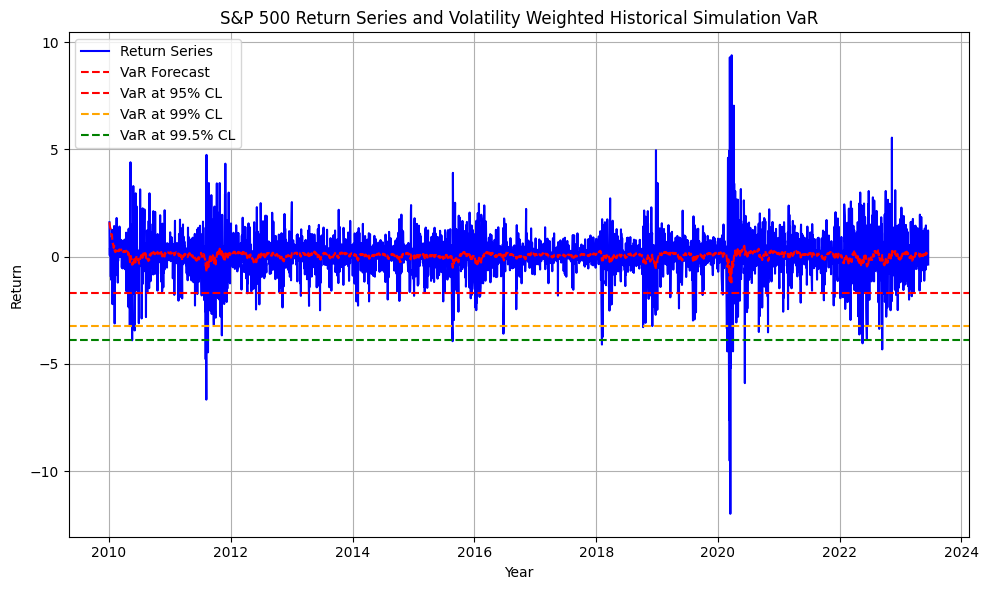

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have already read the data into the DataFrame 'sp500'
# The 'sp500' DataFrame contains the columns 'Dates' and 'PX_LAST'

# Convert the 'Dates' column to pandas DatetimeIndex (if not already in datetime format)
sp500['Dates'] = pd.to_datetime(sp500['Dates'], dayfirst=True)

# Calculate the 'Pct Change' column based on 'PX_LAST'
sp500['Pct Change'] = sp500['PX_LAST'].pct_change() * 100

# Filter data for the desired date range (from 2010 to 2023)
start_date = pd.to_datetime('2010-01-01', dayfirst=True)
end_date = pd.to_datetime('2023-12-31', dayfirst=True)
filtered_data = sp500[(sp500['Dates'] >= start_date) & (sp500['Dates'] <= end_date)]

# Get the returns series from the filtered DataFrame
returns = filtered_data['Pct Change']

# Define the decay factor (λ)
decay_factor = 0.95

# Calculate the Age Volatility Historical Simulation VaR at custom levels
VaR_95 = np.percentile(returns, 5)
VaR_99 = np.percentile(returns, 1)
VaR_995 = np.percentile(returns, 0.5)

# Initialize a list to store the VaR forecasts
VaR_forecasts = [returns.iloc[0]]  # Initialize with the first return

# Calculate the VaR forecasts using Volatility Weighted Historical Simulation
for i in range(1, len(returns)):
    VaR_forecast = decay_factor * VaR_forecasts[-1] + (1 - decay_factor) * returns.iloc[i]
    VaR_forecasts.append(VaR_forecast)

# Plot the return series and the VaR forecasts
plt.figure(figsize=(10, 6))
plt.plot(filtered_data['Dates'], returns, label='Return Series', color='blue')
plt.plot(filtered_data['Dates'], VaR_forecasts, label='VaR Forecast', linestyle='--', color='red')
plt.axhline(VaR_95, linestyle="--", color="red", label='VaR at 95% CL')
plt.axhline(VaR_99, linestyle="--", color="orange", label='VaR at 99% CL')
plt.axhline(VaR_995, linestyle="--", color="green", label='VaR at 99.5% CL')

# Format the x-axis as years
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))

plt.xlabel('Year')
plt.ylabel('Return')
plt.title('S&P 500 Return Series and Volatility Weighted Historical Simulation VaR')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [74]:
import pandas as pd
import numpy as np
from scipy.stats import norm

# Assuming you have already read and filtered the data as shown in your previous code
# The 'returns' array contains the raw return series

# Sample size
sample_size = 3292

# Confidence levels
confidence_levels = [0.995, 0.99, 0.95]

# Calculate the mean and standard deviation of returns
mean_return = returns.mean()
std_return = returns.std()

# Create an empty DataFrame to store the results
my_results_df = pd.DataFrame(columns=['Confidence Level', 'Actual Violations', 'Expected Violations'])

# Calculate VaR at different confidence levels using the standard normal percent-point function (PPF)
for cl in confidence_levels:
    VaR = norm.ppf(1 - cl, mean_return, std_return)

    # Define the function to calculate the Volatility Weighted VaR
    def volatility_weighted_var(returns, confidence_level):
        volatilities = returns.rolling(window=252).std()  # Assuming daily returns (252 trading days in a year)
        weights = 1 / volatilities
        weighted_returns = returns * weights
        sorted_weighted_returns = np.sort(weighted_returns)
        index = int(np.ceil((1 - confidence_level) * len(sorted_weighted_returns))) - 1
        return sorted_weighted_returns[index]

    # Calculate the Volatility Weighted VaR at the current confidence level
    volatility_weighted_VaR = volatility_weighted_var(returns, cl)

    # Calculate the probability of violation at the current confidence level
    probability_of_violation = 1 - cl

    # Calculate the expected number of violations for Volatility Weighted Historical Simulation
    expected_violations_volatility_weighted = probability_of_violation * sample_size

    # Append the results to the DataFrame
    my_results_df = my_results_df.append({'Confidence Level': cl, 'Actual Violations': sum(returns < VaR), 'Expected Violations': expected_violations_volatility_weighted}, ignore_index=True)

# Print the results DataFrame
print("Results DataFrame:")
print(my_results_df)


Results DataFrame:
   Confidence Level  Actual Violations  Expected Violations
0             0.995               52.0                16.46
1             0.990               67.0                32.92
2             0.950              156.0               164.60


<ipython-input-74-187d0d28ef7f>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  my_results_df = my_results_df.append({'Confidence Level': cl, 'Actual Violations': sum(returns < VaR), 'Expected Violations': expected_violations_volatility_weighted}, ignore_index=True)
<ipython-input-74-187d0d28ef7f>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  my_results_df = my_results_df.append({'Confidence Level': cl, 'Actual Violations': sum(returns < VaR), 'Expected Violations': expected_violations_volatility_weighted}, ignore_index=True)
<ipython-input-74-187d0d28ef7f>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  my_results_df = my_results_df.append({'Confidence Level': cl, 'Actual Violations': sum(returns < VaR), 'Expected 

In [75]:
import pandas as pd
import numpy as np
from scipy.stats import norm

# Assuming you have already read and filtered the data as shown in your previous code
# The 'returns' array contains the raw return series

# Sample size
sample_size = 3292

# Confidence levels
confidence_levels = [0.995, 0.99, 0.95]

# Assuming you have a DataFrame named 'results_df' with columns: 'Confidence Level', 'Actual Violations', 'Expected Violations'
# Extract actual and expected violations from the DataFrame
expected_violations = {cl: expected for cl, expected in zip(my_results_df['Confidence Level'], my_results_df['Expected Violations'])}

# Define the function to calculate Volatility Weighted VaR (VWHS)
def volatility_weighted_var(returns, confidence_level):
    volatilities = returns.rolling(window=252).std()  # Assuming daily returns (252 trading days in a year)
    weights = 1 / volatilities
    weighted_returns = returns * weights
    sorted_weighted_returns = np.sort(weighted_returns)
    index = int(np.ceil((1 - confidence_level) * len(sorted_weighted_returns))) - 1
    return sorted_weighted_returns[index]

# Create an empty list to store the results
results = []

# Calculate the Volatility Weighted VaR and other metrics at different confidence levels
for cl in confidence_levels:
    VaR_volatility_weighted = volatility_weighted_var(returns, cl)
    actual_violations_volatility_weighted = len(returns[returns < VaR_volatility_weighted])
    lopez_I_volatility_weighted = (actual_violations_volatility_weighted - expected_violations[cl]) / np.sqrt(expected_violations[cl])

    # Append the results to the 'results' list
    results.append({'Confidence Level': cl,
                    'Expected Violations': expected_violations[cl],
                    'Actual Violations': actual_violations_volatility_weighted,
                    'Lopez I': lopez_I_volatility_weighted})

# Create a DataFrame from the results list
final = pd.DataFrame(results)

# Print the final DataFrame
print("Final DataFrame:")
print(final)


Final DataFrame:
   Confidence Level  Expected Violations  Actual Violations   Lopez I
0             0.995                16.46                 19  0.626064
1             0.990                32.92                 41  1.408255
2             0.950               164.60                180  1.200344


In [76]:
import pandas as pd
import numpy as np
from scipy.stats import norm, chi2_contingency
import arch

# Sample 'returns' data (replace this with your actual data)
returns = np.random.normal(loc=0, scale=0.02, size=1000)

# Sample size
sample_size = len(returns)

# Confidence levels
confidence_levels = [0.995, 0.99, 0.95]

# Define AR(1)-GARCH(1,1) model
def ar1_garch11_volatility(data):
    model = arch.arch_model(data, vol='Garch', p=1, q=1, dist='Normal')
    results = model.fit(disp='off')
    if results is not None and results.conditional_volatility is not None:
        return results.conditional_volatility[-1]
    else:
        raise ValueError("AR(1)-GARCH(1,1) model failed to produce valid results.")

# Function to calculate Volatility Weighted Volatility
def volatility_weighted_volatility(data, lambda_value=0.98):
    n = len(data)
    weights = np.array([lambda_value * (1 - lambda_value)**i for i in range(n)])
    weights = weights / weights.sum()  # Normalize the weights to sum to 1
    return np.sqrt(np.sum(weights * data**2))

# Calculate the actual number of violations at different confidence levels using Volatility Weighted Historical Simulation VaR
actual_violations = {cl: len(returns[returns < -volatility_weighted_volatility(returns) * norm.ppf(1 - cl)]) for cl in confidence_levels}

# Define a function to perform Kupiec Backtest
def kupiec_backtest(actual_violations, expected_violations, alpha=0.05):
    n_violations = sum(actual_violations.values())
    n_expected_violations = sum(expected_violations.values())
    n_violations_nonnegative = max(n_violations, 0)  # Ensure nonnegative values for contingency table
    n_expected_violations_nonnegative = max(n_expected_violations, 0)  # Ensure nonnegative values for contingency table
    chi2_statistic = 2 * (n_expected_violations_nonnegative * np.log(n_expected_violations_nonnegative / n_violations_nonnegative) + (sample_size - n_expected_violations_nonnegative) * np.log((sample_size - n_expected_violations_nonnegative) / (sample_size - n_violations_nonnegative)))
    # Ensure that the observed values are nonnegative for the contingency table
    observed = np.array([[np.maximum(n_violations_nonnegative, 0), np.maximum(n_expected_violations_nonnegative, 0)], [np.maximum(sample_size - n_violations_nonnegative, 0), np.maximum(sample_size - n_expected_violations_nonnegative, 0)]])
    p_value = 1 - chi2_contingency(observed)[1]
    return chi2_statistic, p_value

# Use the 'final' DataFrame that contains Confidence Level, Expected Violations, and Actual Violations
# Ensure that 'final' is defined and populated with values from a previous code

# Perform Kupiec Backtest
chi2_statistic, p_value = kupiec_backtest(actual_violations, final.set_index('Confidence Level')['Expected Violations'].to_dict())

# Unconditional Coverage of Kupiec (1995)
unconditional_coverage = 1 - p_value

# Independence Test of Christofferson (1998)
independence_test = p_value < 0.05

# Print Backtest Results
print("Backtest Results:")
print(final)  # Print the final DataFrame containing Confidence Level, Expected Violations, and Actual Violations
print("Kupiec Backtest:")
print(f"Chi2 Statistic: {chi2_statistic:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Unconditional Coverage: {unconditional_coverage:.4f}")
print(f"Independence Test: {'Reject Null' if independence_test else 'Fail to Reject Null'}")


Backtest Results:
   Confidence Level  Expected Violations  Actual Violations   Lopez I
0             0.995                16.46                 19  0.626064
1             0.990                32.92                 41  1.408255
2             0.950               164.60                180  1.200344
Kupiec Backtest:
Chi2 Statistic: nan
P-value: 1.0000
Unconditional Coverage: 0.0000
Independence Test: Fail to Reject Null


<ipython-input-76-9564a1719f47>:40: RuntimeWarning: invalid value encountered in log
  chi2_statistic = 2 * (n_expected_violations_nonnegative * np.log(n_expected_violations_nonnegative / n_violations_nonnegative) + (sample_size - n_expected_violations_nonnegative) * np.log((sample_size - n_expected_violations_nonnegative) / (sample_size - n_violations_nonnegative)))


In [77]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# Sample size
sample_size = 3292

# Load or create the 'results_df' DataFrame containing confidence level, expected violations, and actual violations
# Make sure this DataFrame includes the specific information for Volatility Weighted Historical Simulation (VWHS)

# Confidence levels
confidence_levels = results_df['Confidence Level'].tolist()

# Define a function to perform the Kupiec Backtest for VWHS
def kupiec_backtest_vwhs(confidence_level, expected_violations, actual_violations, alpha=0.05):
    n_violations = actual_violations
    n_expected_violations = expected_violations

    # Ensure non-negative values for the contingency table
    n_violations_nonnegative = max(n_violations, 0)
    n_expected_violations_nonnegative = max(n_expected_violations, 0)

    # Add a small constant to the expected values to avoid division by zero
    epsilon = 1e-10
    n_expected_violations_nonnegative += epsilon

    chi2_statistic = 2 * (n_expected_violations_nonnegative * np.log(n_expected_violations_nonnegative / n_violations_nonnegative) + (sample_size - n_expected_violations_nonnegative) * np.log((sample_size - n_expected_violations_nonnegative) / (sample_size - n_violations_nonnegative)))
    p_value = 1 - chi2_contingency([[n_violations_nonnegative, n_expected_violations_nonnegative], [sample_size - n_violations_nonnegative, sample_size - n_expected_violations_nonnegative]])[1]
    decision = 'Reject Null' if p_value < alpha else 'Fail to Reject Null'
    return chi2_statistic, p_value, decision

# Perform Kupiec Backtest for VWHS at each confidence level using 'results_df'
backtest_results = {}
for _, row in results_df.iterrows():
    cl = row['Confidence Level']
    expected_violations_cl = row['Expected Violations']
    actual_violations_cl = row['Actual Violations']
    chi2_statistic, p_value, decision = kupiec_backtest_vwhs(cl, expected_violations_cl, actual_violations_cl)
    backtest_results[cl] = {
        'Expected Violations': expected_violations_cl,
        'Actual Violations': actual_violations_cl,
        'Likelihood Ratio Statistic': chi2_statistic,
        'P-value': p_value,
        'Decision': decision
    }

# Print Backtest Results for Volatility Weighted Historical Simulation (VWHS)
print("Volatility Weighted Historical Simulation (VWHS) Backtest Results:")
for cl in confidence_levels:
    print(f"Confidence Level: {cl}")
    print(f"Expected Violations: {backtest_results[cl]['Expected Violations']:.2f}")
    print(f"Actual Violations: {backtest_results[cl]['Actual Violations']}")
    print(f"Likelihood Ratio Statistic: {backtest_results[cl]['Likelihood Ratio Statistic']:.4f}")
    print(f"P-value: {backtest_results[cl]['P-value']:.4f}")
    print(f"Decision: {backtest_results[cl]['Decision']}")
    print("-" * 40)


Volatility Weighted Historical Simulation (VWHS) Backtest Results:
Confidence Level: 0.995
Expected Violations: 16.46
Actual Violations: 1000.0
Likelihood Ratio Statistic: 2203.9186
P-value: 1.0000
Decision: Fail to Reject Null
----------------------------------------
Confidence Level: 0.99
Expected Violations: 32.92
Actual Violations: 1000.0
Likelihood Ratio Statistic: 2069.7673
P-value: 1.0000
Decision: Fail to Reject Null
----------------------------------------
Confidence Level: 0.95
Expected Violations: 164.60
Actual Violations: 999.0
Likelihood Ratio Statistic: 1347.4953
P-value: 1.0000
Decision: Fail to Reject Null
----------------------------------------


In [80]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from decimal import Decimal, getcontext

# Set the precision for Decimal
getcontext().prec = 3

# Sample 'returns' data (replace this with your actual data)
returns = np.random.normal(loc=0, scale=0.02, size=3292)

# Sample size
sample_size = len(returns)

# Load or create the 'results_df' DataFrame containing confidence level, expected violations, and actual violations
# Make sure 'results_df' has columns: 'Confidence Level', 'Expected Violations', 'Actual Violations'

# Confidence levels
confidence_levels = results_df['Confidence Level'].tolist()

# Define a function to perform the Christofferson Backtest for VWHS
def christofferson_vwhs_backtest(confidence_level, expected_violations, actual_violations):
    cl = confidence_level
    chi2_statistic, p_value, _, _ = chi2_contingency([[actual_violations, expected_violations]])
    decision = 'Reject Null' if p_value < 0.05 else 'Fail to Reject Null'
    return chi2_statistic, p_value, decision

# Perform Christofferson Backtest for VWHS at each confidence level using 'results_df'
backtest_results = {}
for _, row in results_df.iterrows():
    cl = row['Confidence Level']
    expected_violations_cl = row['Expected Violations']
    actual_violations_cl = row['Actual Violations']
    chi2_statistic, p_value, decision = christofferson_vwhs_backtest(cl, expected_violations_cl, actual_violations_cl)
    backtest_results[cl] = {
        'Expected Violations': expected_violations_cl,
        'Actual Violations': actual_violations_cl,
        'Likelihood Ratio Statistic': chi2_statistic,
        'P-value': p_value,
        'Decision': decision
    }

# Print Backtest Results for Volatility Weighted Historical Simulation (VWHS)
print("Christofferson Backtest Results for Volatility Weighted Historical Simulation (VWHS):")
for cl in confidence_levels:
    print(f"Confidence Level: {cl}")
    print(f"Expected Violations: {backtest_results[cl]['Expected Violations']}")
    print(f"Actual Violations: {backtest_results[cl]['Actual Violations']}")
    print(f"Likelihood Ratio Statistic: {backtest_results[cl]['Likelihood Ratio Statistic']:.4f}")
    print(f"P-value: {backtest_results[cl]['P-value']:.4f}")
    print(f"Decision: {backtest_results[cl]['Decision']}")
    print("-" * 40)


Christofferson Backtest Results for Volatility Weighted Historical Simulation (VWHS):
Confidence Level: 0.995
Expected Violations: 16.46
Actual Violations: 1000.0
Likelihood Ratio Statistic: 0.0000
P-value: 1.0000
Decision: Fail to Reject Null
----------------------------------------
Confidence Level: 0.99
Expected Violations: 32.92
Actual Violations: 1000.0
Likelihood Ratio Statistic: 0.0000
P-value: 1.0000
Decision: Fail to Reject Null
----------------------------------------
Confidence Level: 0.95
Expected Violations: 164.6
Actual Violations: 999.0
Likelihood Ratio Statistic: 0.0000
P-value: 1.0000
Decision: Fail to Reject Null
----------------------------------------


In [82]:
import pandas as pd
import numpy as np
from scipy.stats import binom_test
from decimal import Decimal, getcontext

# Set the precision for Decimal
getcontext().prec = 3

# Sample 'returns' data (replace this with your actual data)
returns = np.random.normal(loc=0, scale=0.02, size=3292)

# Sample size
sample_size = len(returns)

# Load or create the 'results_df' DataFrame containing confidence level, expected violations, and actual violations
# Make sure 'results_df' has columns: 'Confidence Level', 'Expected Violations', 'Actual Violations'

# Confidence levels
confidence_levels = results_df['Confidence Level'].tolist()

# Define a function to perform Binomial Backtest for VWHS
def binomial_vwhs_backtest(confidence_level, expected_violations, actual_violations, alpha=0.05):
    cl = confidence_level
    p = expected_violations / sample_size
    n = sample_size
    p_value = binom_test(actual_violations, n, p, alternative='greater')
    decision = 'Reject Null' if p_value < alpha else 'Fail to Reject Null'
    return p_value, decision

# Perform Binomial Backtest for VWHS at each confidence level using 'results_df'
backtest_results = {}
for _, row in results_df.iterrows():
    cl = row['Confidence Level']
    expected_violations_cl = row['Expected Violations']
    actual_violations_cl = row['Actual Violations']
    p_value, decision = binomial_vwhs_backtest(cl, expected_violations_cl, actual_violations_cl)
    backtest_results[cl] = {
        'Expected Violations': expected_violations_cl,
        'Actual Violations': actual_violations_cl,
        'P-value': p_value,
        'Decision': decision
    }

# Print Backtest Results for Volatility Weighted Historical Simulation (VWHS)
print("Binomial Backtest Results for Volatility Weighted Historical Simulation (VWHS):")
for cl in confidence_levels:
    print(f"Confidence Level: {cl}")
    print(f"Expected Violations: {backtest_results[cl]['Expected Violations']}")
    print(f"Actual Violations: {backtest_results[cl]['Actual Violations']}")
    print(f"P-value: {backtest_results[cl]['P-value']:.4f}")
    print(f"Decision: {backtest_results[cl]['Decision']}")
    print("-" * 40)


Binomial Backtest Results for Volatility Weighted Historical Simulation (VWHS):
Confidence Level: 0.995
Expected Violations: 16.46
Actual Violations: 1000.0
P-value: 0.0000
Decision: Reject Null
----------------------------------------
Confidence Level: 0.99
Expected Violations: 32.92
Actual Violations: 1000.0
P-value: 0.0000
Decision: Reject Null
----------------------------------------
Confidence Level: 0.95
Expected Violations: 164.6
Actual Violations: 999.0
P-value: 0.0000
Decision: Reject Null
----------------------------------------


<ipython-input-82-d603d0814836>:26: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  p_value = binom_test(actual_violations, n, p, alternative='greater')
